In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.io import read_image
import torchvision.transforms as T
import torchmetrics
# import albumentations

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from evaluate import load

import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 500
import matplotlib.image as mpimg
import pandas as pd

import os
import glob
from os import path
from pathlib import Path
from tqdm import tqdm

import cv2
from PIL import Image, ImageFile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Подгрузим данные

In [ ]:
# ! unzip -O utf8 "/content/drive/MyDrive/CCPD2019-dl1.zip"

Обозначим config

In [ ]:
TRAIN_DIR =  r"/content/CCPD2019-dl1/train"
TEST_DIR =  r"/content/CCPD2019-dl1/test"
BATCH_SIZE = 8
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 75
NUM_WORKERS = 8
EPOCHS = 3

### Подготовка данных

Создадим наш датасет

In [ ]:
class Dataset:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize

        #используем стандартное преобразование как у imagenet
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        self.aug = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean, std,
                )
            ]
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        targets = self.targets[item]

        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]), resample=Image.BILINEAR
            )

        return {
            "images": self.aug(image),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

Получим общий алфавит, с которым мы будем работать

In [ ]:
#получаем таргеты
train_image_files = glob.glob(os.path.join(TRAIN_DIR, "*.jpg"))
train_targets_orig = [x.split("/")[-1][-11:-4] for x in train_image_files]

test_image_files = glob.glob(os.path.join(TEST_DIR, "*.jpg"))
test_targets_orig = [x.split("/")[-1][-11:-4] for x in test_image_files]

#все возможные таргеты
targets_orig = train_targets_orig + test_targets_orig

будем использовать встроенный энкодер, чтобы было удобнее

In [ ]:
#делаем алфавит
targets = [[c for c in x] for x in targets_orig]
targets_flat = [c for clist in targets for c in clist]

#кодируем
lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(targets_flat)

LabelEncoder()

общее колическо полученных классов (понадобиться дальше)

In [ ]:
#сколько у нас классов
len(lbl_enc.classes_)

66

In [ ]:
#кодируем трейн
train_targets = [[c for c in x] for x in train_targets_orig]
train_targets_enc = [lbl_enc.transform(x) for x in train_targets]
train_targets_enc = np.array(train_targets_enc)
train_targets_enc = train_targets_enc + 1

#кодируем тест
test_targets = [[c for c in x] for x in test_targets_orig]
test_targets_enc = [lbl_enc.transform(x) for x in test_targets]
test_targets_enc = np.array(test_targets_enc)
test_targets_enc = test_targets_enc + 1

Разобьем трейн на трейн и валидацию


In [ ]:
(
    train_imgs, valid_imgs, train_targets, valid_targets, _, valid_targets_orig,
) = model_selection.train_test_split(
        train_image_files, train_targets_enc, train_targets_orig, test_size=0.1, random_state=42
    )

Создадим датасеты

In [ ]:
train_dataset = Dataset(
        image_paths=train_imgs,
        targets=train_targets,
        resize=(IMAGE_HEIGHT, IMAGE_WIDTH),
    )

In [ ]:
valid_dataset = Dataset(
        image_paths=valid_imgs,
        targets=valid_targets,
        resize=(IMAGE_HEIGHT, IMAGE_WIDTH),
    )

In [ ]:
test_dataset = Dataset(
        image_paths=test_image_files,
        targets=test_targets_enc,
        resize=(IMAGE_HEIGHT, IMAGE_WIDTH),
    )

Теперь DataLoader

In [ ]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        #num_workers=NUM_WORKERS,
        shuffle=True,
    )

In [ ]:
valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        #num_workers=NUM_WORKERS,
        shuffle=False,
    )

In [ ]:
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        #num_workers=NUM_WORKERS,
        shuffle=False,
    )

Проверим что все работает

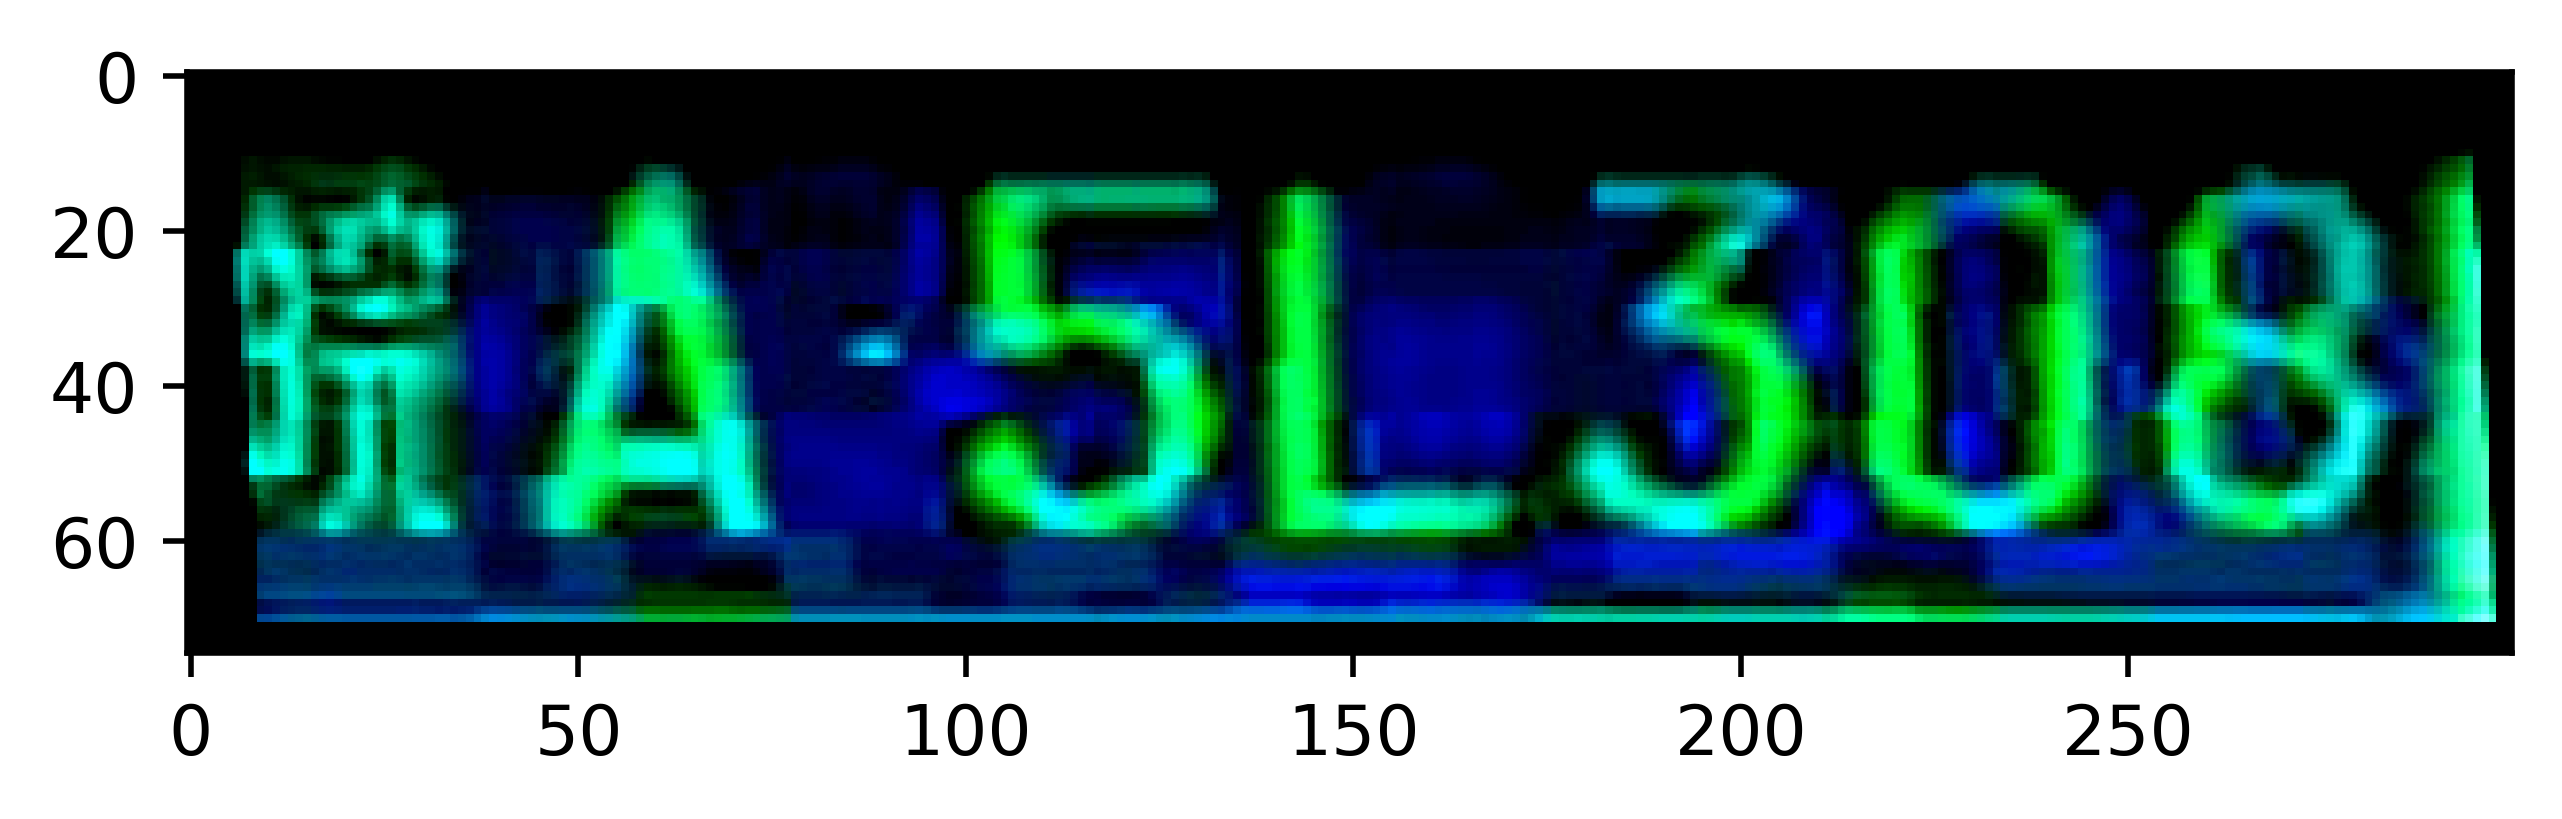

In [ ]:
tmp = next(iter(train_loader))
plt.imshow(tmp['images'][0].permute(1, 2, 0))

Таже проверим размер картинки (все супер)

In [ ]:
tmp['images'][0].shape

torch.Size([3, 75, 300])

### Создание и обучение модели

Создадим модель по предложенной схеме

In [ ]:
class OcrModel(nn.Module):
    def __init__(self, num_chars):
        super().__init__()

        #будем идти прямоугольным ядром тк картина прямоугольная 
        self.conv_1 = nn.Conv2d(3, 128, kernel_size=(3, 6), padding=(1, 1))
        self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3, 6), padding=(1, 1))
        self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))
 

        self.linear_1 = nn.Linear(1152, 64)
        self.drop_1 = nn.Dropout(0.2)

        self.lstm = nn.LSTM(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        #преобразуем под количесво классов 
        self.output = nn.Linear(64, num_chars + 1)

    def forward(self, images, targets=None):
        bs, _, _, _ = images.size()

        x = F.relu(self.conv_1(images)) # 1, 128, 75, 297
        x = self.pool_1(x) # 1, 128, 37, 148

        x = F.relu(self.conv_2(x)) # 1, 64, 37, 145
        x = self.pool_2(x) # 1, 64, 18, 72

        x = x.permute(0, 3, 1, 2) # 1, 72, 64, 18
        x = x.view(bs, x.size(1), -1) # 1, 72, 1152

        x = F.relu(self.linear_1(x)) #1, 72, 64
        x = self.drop_1(x) # 1, 72, 64

        x, _ = self.lstm(x) # 1, 72, 64
        x = self.output(x) # 1, 72, 67

        #делаем необходимую перестановку для передачи в стс лосс
        x = x.permute(1, 0, 2) # 72, 1, 67

        if targets is not None:
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(
                size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32
            )
            target_lengths = torch.full(
                size=(bs,), fill_value=targets.size(1), dtype=torch.int32
            )
            loss = nn.CTCLoss(blank=0)(
                log_probs, targets, input_lengths, target_lengths
            )
            return x, loss

        return x, None

произведем проверку что все работает:

In [ ]:
# cm = OcrModel(66)
# img = torch.rand((1, 3, 75, 300))
# x, _ = cm(img, torch.rand((1, 5)))

инициализируем модель

In [ ]:
model = OcrModel(num_chars=len(lbl_enc.classes_))
model.to(device)

OcrModel(
  (conv_1): Conv2d(3, 128, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(128, 64, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1152, out_features=64, bias=True)
  (drop_1): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(64, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=67, bias=True)
)

В качесве оптимизатора возьмем Адам

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)

определим train и eval

In [ ]:
def train_fn(model, data_loader, optimizer):
    model.train()
    fin_loss = 0

    tk0 = tqdm(data_loader, total=len(data_loader))
    for data in tk0:
        for key, value in data.items():
            data[key] = value.to(device)
        
        optimizer.zero_grad()
        _, loss = model(data['images'], data['targets'])

        loss.backward()
        optimizer.step()

        fin_loss += loss.item()
        
    return fin_loss / len(data_loader)

In [ ]:
def eval_fn(model, data_loader):
    model.eval()
    fin_loss = 0

    fin_preds = []
    tk0 = tqdm(data_loader, total=len(data_loader))

    with torch.no_grad():
        for data in tk0:
            for key, value in data.items():
                data[key] = value.to(device)

            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            
            fin_preds.append(batch_preds)

    return fin_preds, fin_loss / len(data_loader)

Теперь сделаем декодер

Он должен выполнять две функции:

1) удаление повторов среди подряд идущих символов

2) удаление пустых символов

In [ ]:
def remove_duplicates(x):
    if len(x) < 2:
        return x
    fin = ""
    for j in x:
        if fin == "":
            fin = j
        else:
            if j == fin[-1]:
                continue
            else:
                fin = fin + j
    return fin

In [ ]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    #выбираем наиболее вероятных символ по предсказаниям
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()

    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            k -= 1
            if k == -1:
                temp.append("+") #символ который не встречается
            else:
                p = encoder.inverse_transform([k])[0] #декодиркем
                temp.append(p)
        
        temp = "".join(temp)
        temp = remove_duplicates(temp) #выполняем задачу декодера 1)
        tp = "".join(temp).replace("+", "") #выполняем задачу декодера 2)
        cap_preds.append(tp) 
    return cap_preds


In [ ]:
for epoch in range(EPOCHS):

    train_loss = train_fn(model, train_loader, optimizer)
    valid_preds, test_loss = eval_fn(model, valid_loader)
    
    valid_number_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_number_preds.extend(current_preds)

    combined = list(zip(valid_targets_orig, valid_number_preds))
    print(combined[:10])

    valid_dup_rem = [remove_duplicates(c) for c in valid_targets_orig]
    accuracy = metrics.accuracy_score(valid_dup_rem, valid_number_preds)

    print(
        f"Epoch={epoch}, Train Loss={train_loss}, Evaluation={test_loss} Accuracy={accuracy}"
    )

    scheduler.step(test_loss)

100%|██████████| 2500/2500 [04:21<00:00,  9.54it/s]


[('皖A6T964', '皖A6T964'), ('皖A08M75', '皖A08M75'), ('皖AWY706', '皖AWY706'), ('皖AX116D', '皖AX16D'), ('皖A9J230', '皖A9J230'), ('皖NPM377', '皖NPM37'), ('皖AB926B', '皖AB926B'), ('皖AX215P', '皖AX215P'), ('皖AB0B59', '皖AB0B59'), ('皖AW6G35', '皖AW6G35')]
Epoch=0, Train Loss=0.015098414474653599, Evaluation=0.00833991790873697 Accuracy=0.9882988298829883


100%|██████████| 2500/2500 [04:21<00:00,  9.57it/s]


[('皖A6T964', '皖A6T964'), ('皖A08M75', '皖A08M75'), ('皖AWY706', '皖AWY706'), ('皖AX116D', '皖AX16D'), ('皖A9J230', '皖A9J230'), ('皖NPM377', '皖NPM37'), ('皖AB926B', '皖AB926B'), ('皖AX215P', '皖AX215P'), ('皖AB0B59', '皖AB0B59'), ('皖AW6G35', '皖AW6G35')]
Epoch=1, Train Loss=0.009843402019266072, Evaluation=0.0057467854574060765 Accuracy=0.9918491849184918


100%|██████████| 2500/2500 [04:21<00:00,  9.57it/s]


[('皖A6T964', '皖A6T964'), ('皖A08M75', '皖A08M75'), ('皖AWY706', '皖AWY706'), ('皖AX116D', '皖AX16D'), ('皖A9J230', '皖A9J230'), ('皖NPM377', '皖NPM37'), ('皖AB926B', '皖AB926B'), ('皖AX215P', '皖AX215P'), ('皖AB0B59', '皖AB0B59'), ('皖AW6G35', '皖AW6G35')]
Epoch=2, Train Loss=0.007830326208543037, Evaluation=0.0045487869668773785 Accuracy=0.9937993799379938


Сохраняем полученную модель

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model.pt')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model.pt'))

<All keys matched successfully>

### Подсчет метрик

получим предсказания на тесте

In [ ]:
test_preds, test_loss = eval_fn(model, test_loader)

100%|██████████| 1250/1250 [02:19<00:00,  8.95it/s]


In [ ]:
number_preds = []

for vp in test_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        number_preds.extend(current_preds)

combined = list(zip(test_targets_orig, number_preds))
print(combined[:10])

[('皖A96Z09', '皖A96Z09'), ('皖NY667C', '皖NY667C'), ('皖AJ915C', '皖A916C'), ('皖A7X333', '皖A7X333'), ('皖AZJ159', '皖AZJ159'), ('皖AB5W66', '皖AB5W66'), ('皖AL7A65', '皖AL7A65'), ('皖AD817D', '皖AD817D'), ('皖AVW733', '皖AVW733'), ('皖AZA213', '皖AZA213')]


посчитаем accuracy

In [ ]:
metrics.accuracy_score(test_targets_orig, number_preds)

0.9707970797079708

посчитаем Character Error Rate

In [ ]:
torchmetrics.functional.char_error_rate(number_preds, test_targets_orig)

tensor(0.0055)

### Анализ ошибок модели

In [ ]:
img_name, ocr_output = zip(*combined)

In [ ]:
df_output = pd.DataFrame({'img_name' : img_name, 'ocr_output' : ocr_output})

In [ ]:
df_output.head()

,img_name,ocr_output
0,皖A96Z09,皖A96Z09
1,皖NY667C,皖NY667C
2,皖AJ915C,皖A916C
3,皖A7X333,皖A7X333
4,皖AZJ159,皖AZJ159


In [ ]:
df_output.shape[0]

9999

In [ ]:
df_output['cer'] = ''

for i in range(df_output.shape[0]):
  ref = df_output.loc[i, 'img_name']
  output = df_output.loc[i, 'ocr_output']
  df_output.loc[i, 'cer'] = torchmetrics.functional.char_error_rate(output, ref) 

In [ ]:
df_output.head()

,img_name,ocr_output,cer
0,皖A96Z09,皖A96Z09,tensor(0.)
1,皖NY667C,皖NY667C,tensor(0.)
2,皖AJ915C,皖A916C,tensor(0.2857)
3,皖A7X333,皖A7X333,tensor(0.)
4,皖AZJ159,皖AZJ159,tensor(0.)


посмотрим на самые ошибочные случаи

In [ ]:
df_output.sort_values( 
        by = ["cer"], 
        ascending = False )[:50]

,img_name,ocr_output,cer
5782,皖AK927W,皖ZZ,tensor(0.8571)
8342,皖ASW824,渝GW43,tensor(0.8571)
4487,皖AF888S,皖AT99,tensor(0.7143)
6998,皖AN8N55,皖AFF,tensor(0.7143)
4492,皖A2W003,皖A2G332,tensor(0.5714)
7284,皖APY862,皖A9PV8Z,tensor(0.5714)
2781,皖AMQ059,皖A0G39,tensor(0.5714)
9619,皖AZ7M69,皖AQ119,tensor(0.5714)
4913,皖AY915C,皖AX9SC,tensor(0.4286)
108,皖AW968W,皖AK68,tensor(0.4286)


In [ ]:
err = list(df_output.sort_values( 
        by = ["cer"], 
        ascending = False )[:50]['img_name'])

In [ ]:
test_image_files = glob.glob(os.path.join(TEST_DIR, "*.jpg"))

In [ ]:
err_pic = []

for i in err:
  for j in test_image_files:
    if j.find(i)!=-1:
      err_pic.append(j)
      break

посмотрим глазками что могло пойти не так

In [ ]:
err_targets = [[c for c in x] for x in err]
err_targets_enc = [lbl_enc.transform(x) for x in err_targets]
err_targets_enc = np.array(err_targets_enc)
err_targets_enc = err_targets_enc + 1

In [ ]:
err_dataset = Dataset(
        image_paths=err_pic,
        targets=err_targets_enc ,
        resize=(IMAGE_HEIGHT, IMAGE_WIDTH),
    )

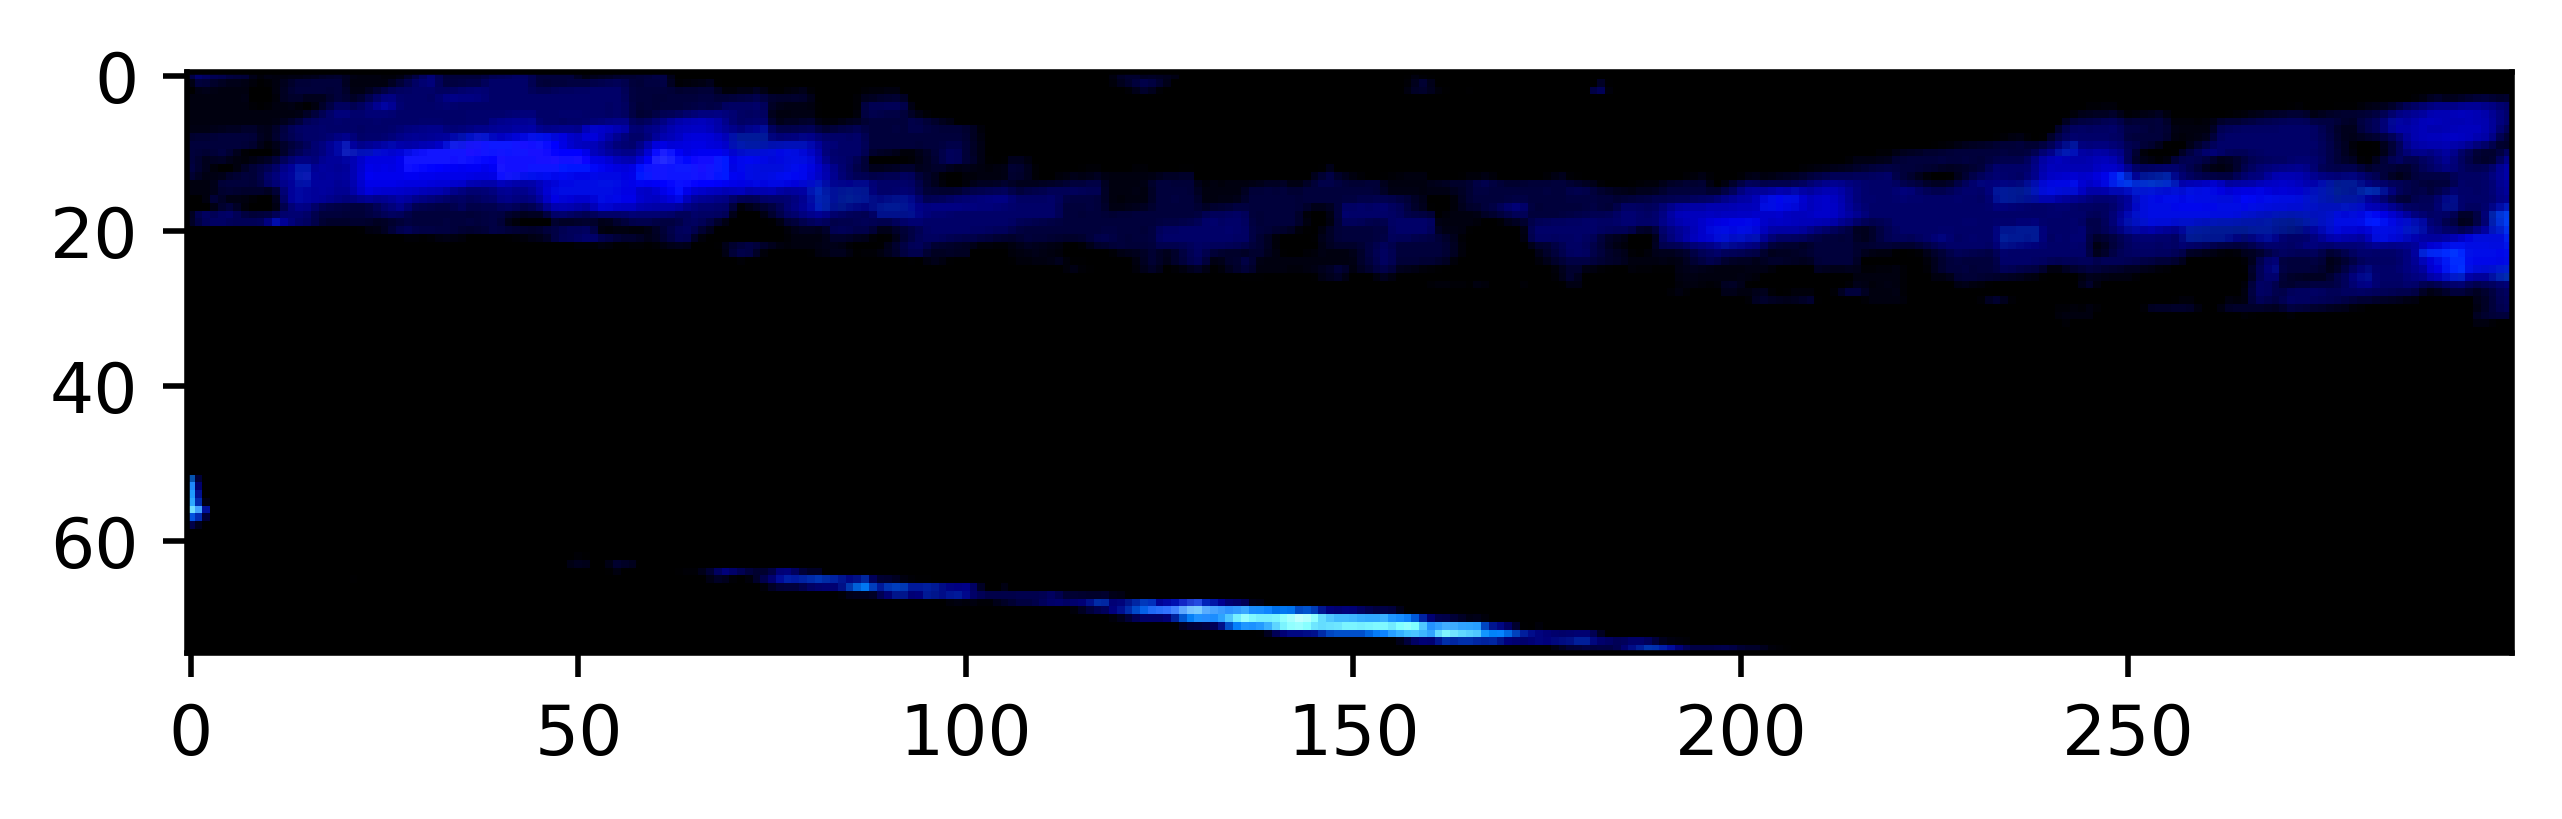

In [ ]:
plt.imshow(err_dataset.__getitem__(0)['images'].permute(1, 2, 0))

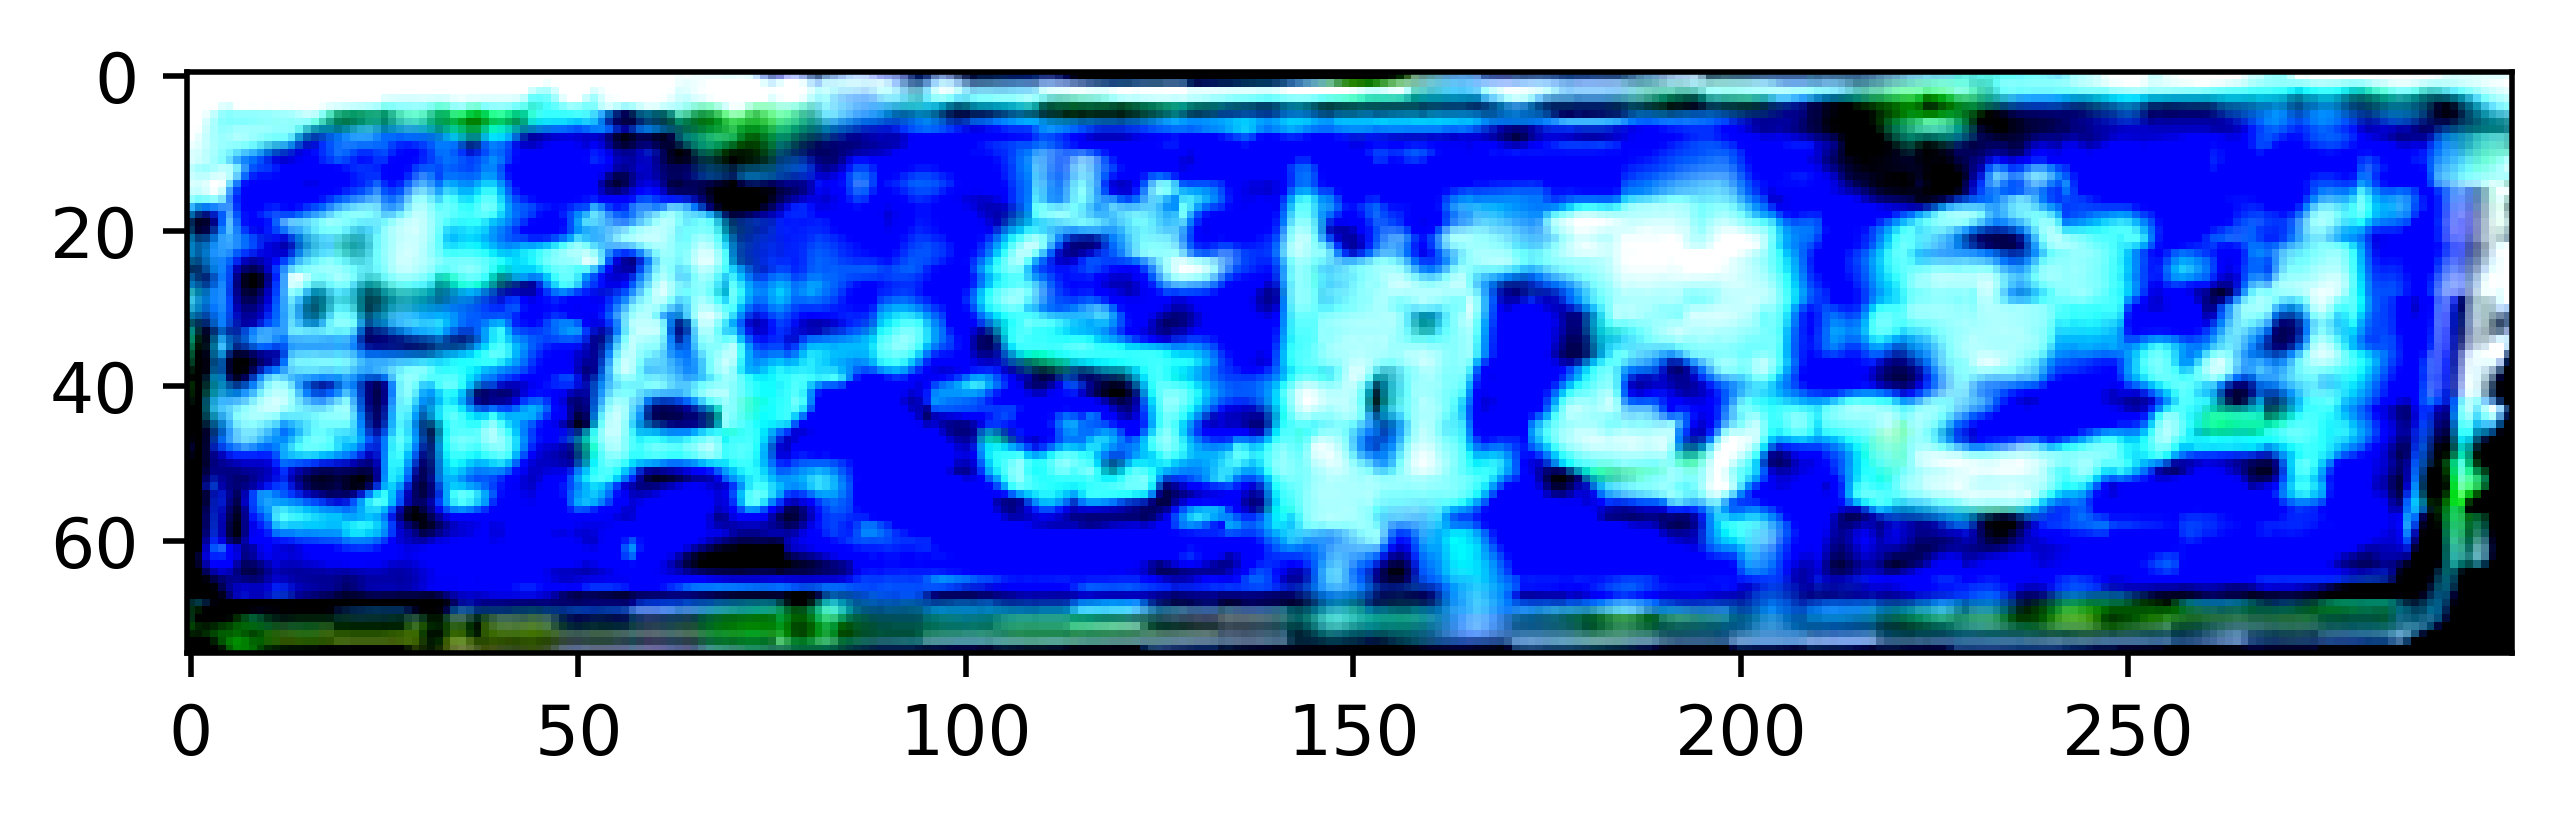

In [ ]:
plt.imshow(err_dataset.__getitem__(1)['images'].permute(1, 2, 0))

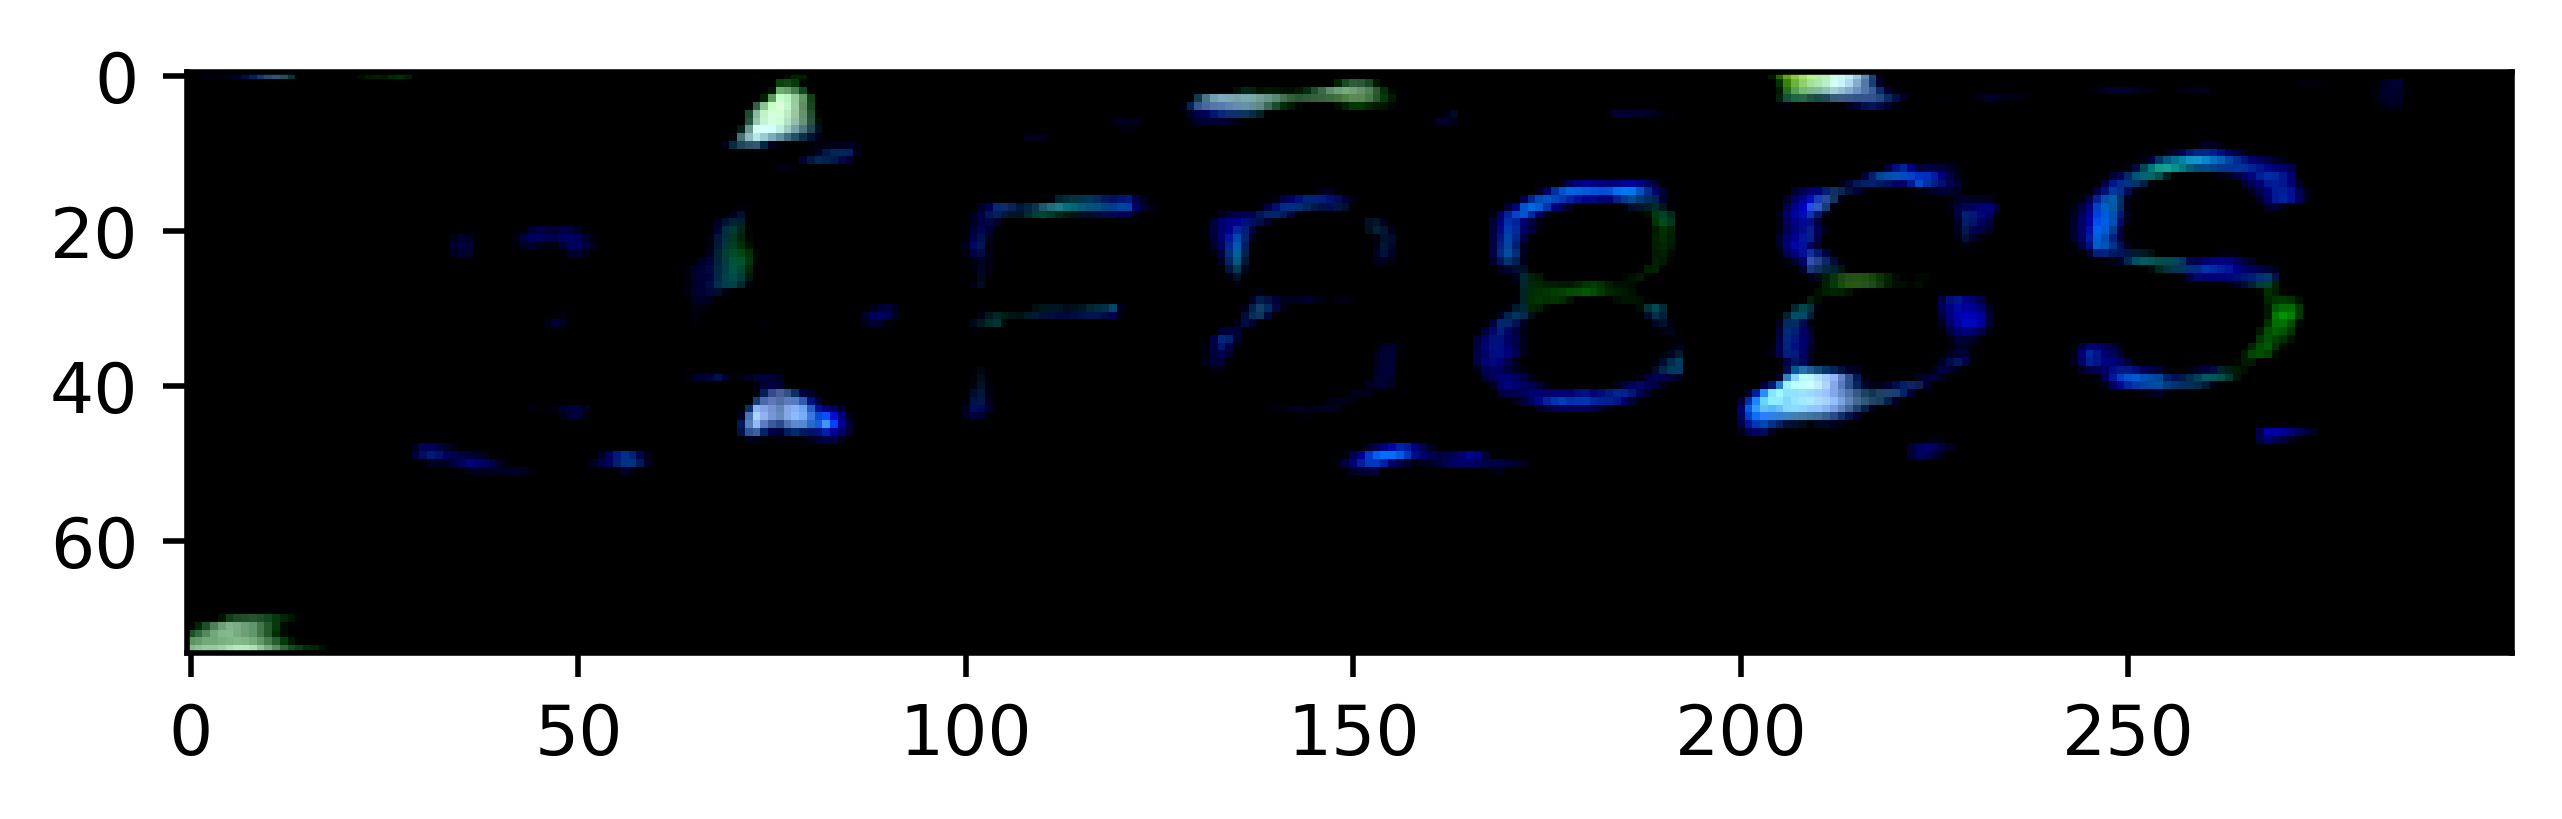

In [ ]:
plt.imshow(err_dataset.__getitem__(2)['images'].permute(1, 2, 0))

ага..... посмотрим как наша картинка выглядит без Normalize

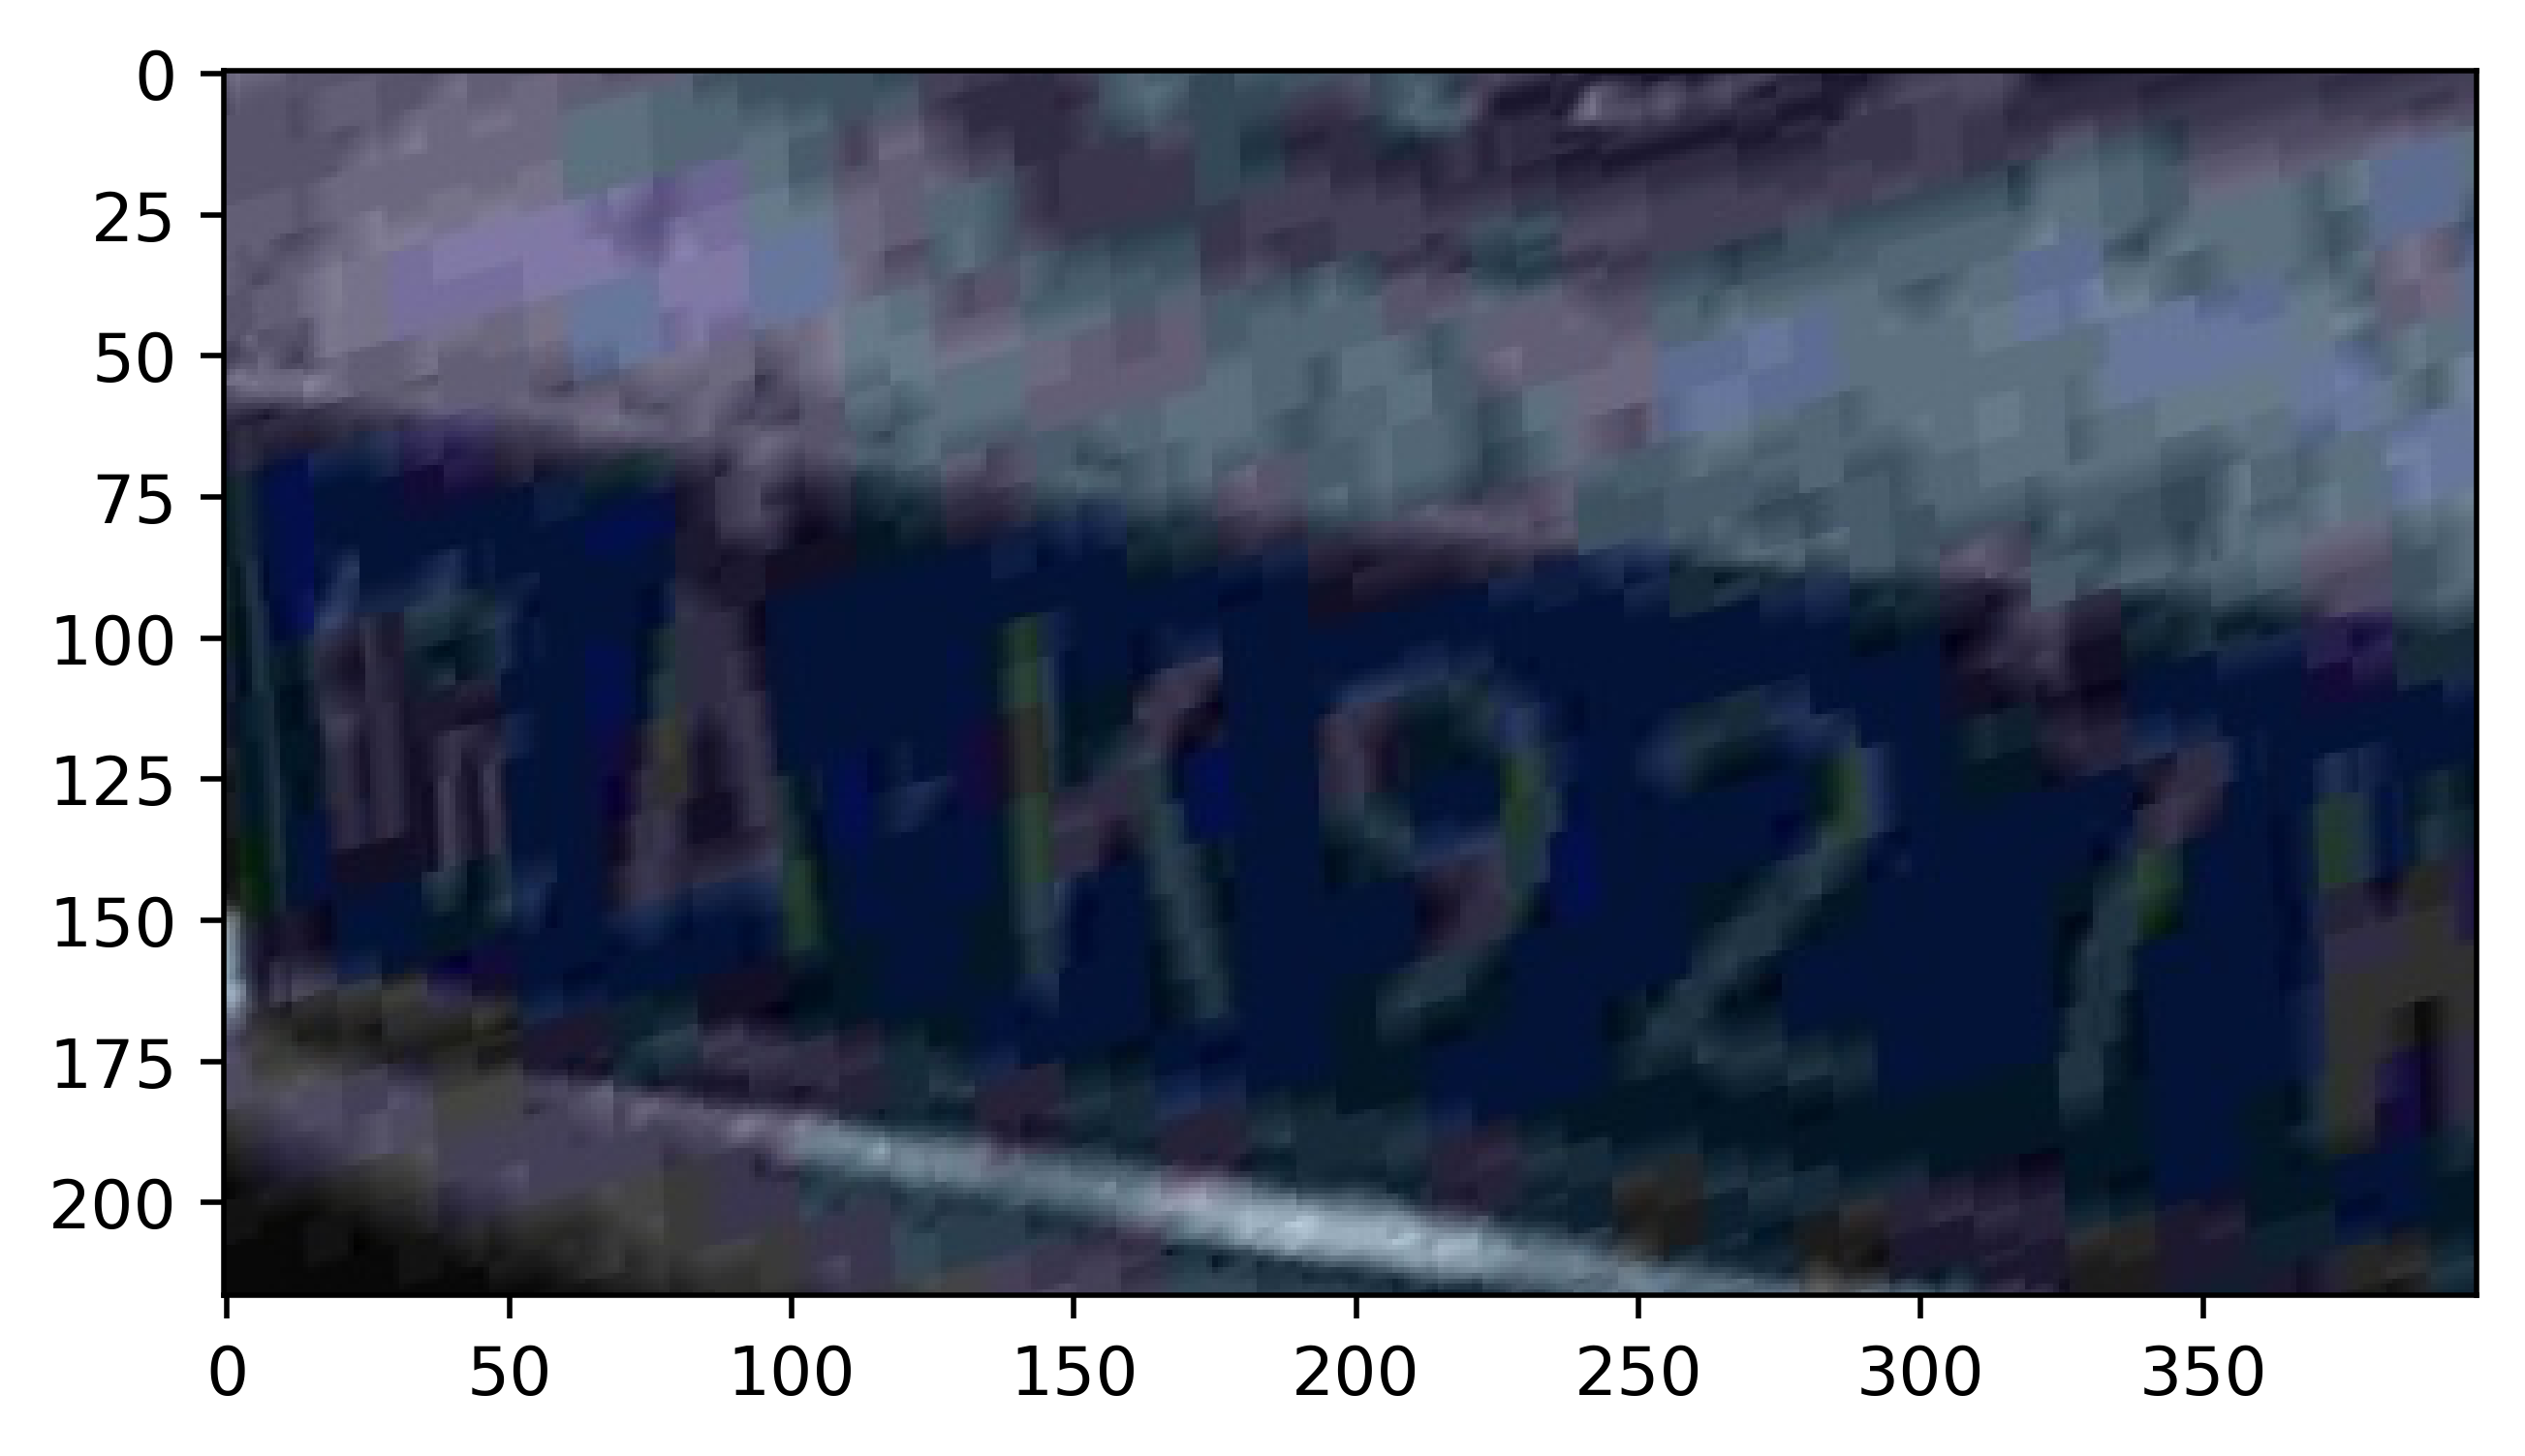

In [ ]:
plt.imshow(Image.open(err_pic[0]))

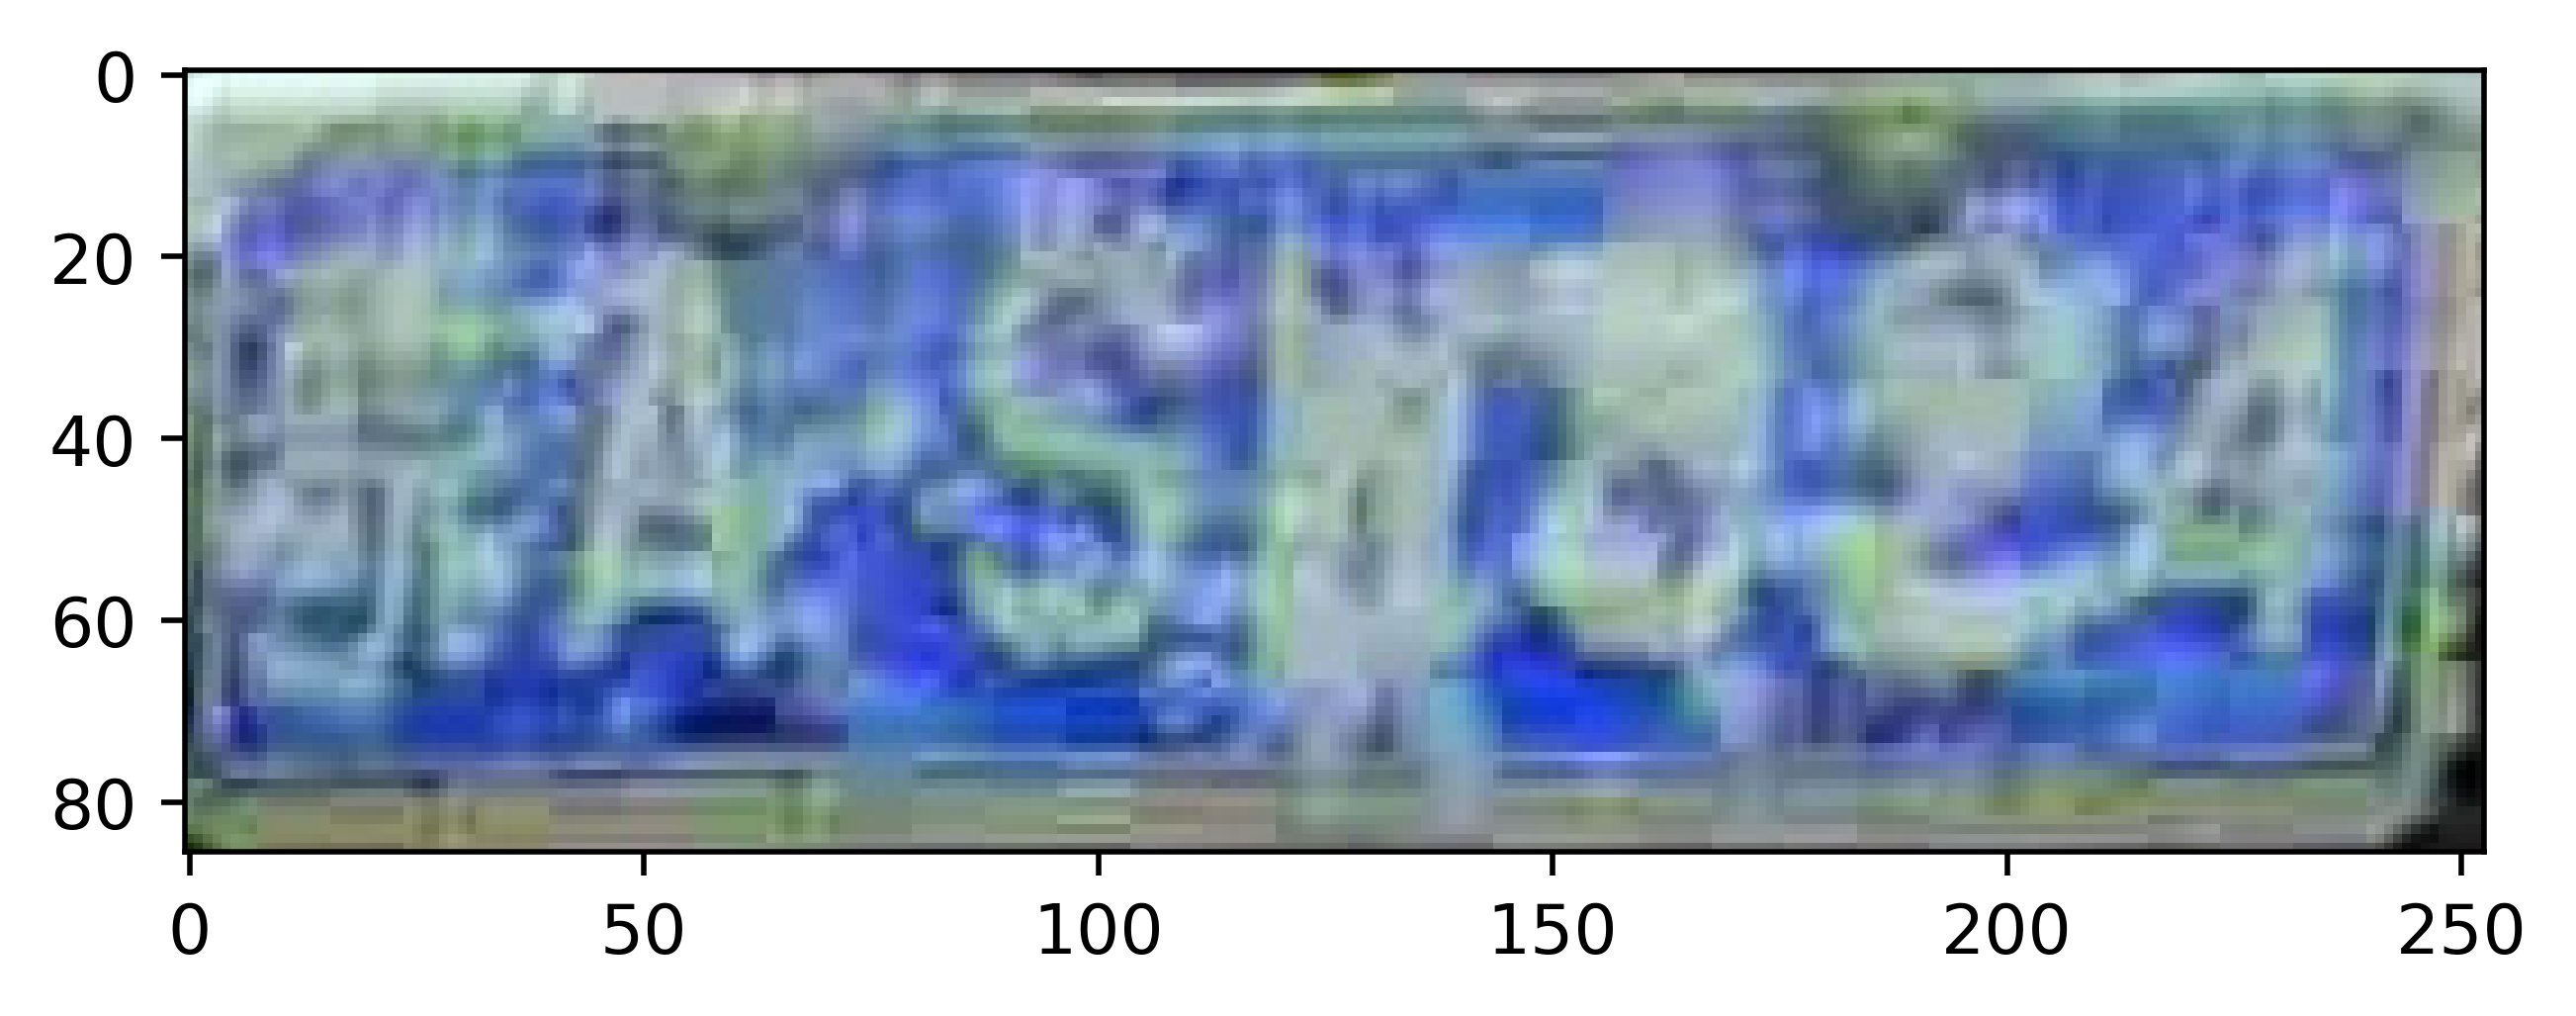

In [ ]:
plt.imshow(Image.open(err_pic[1]))

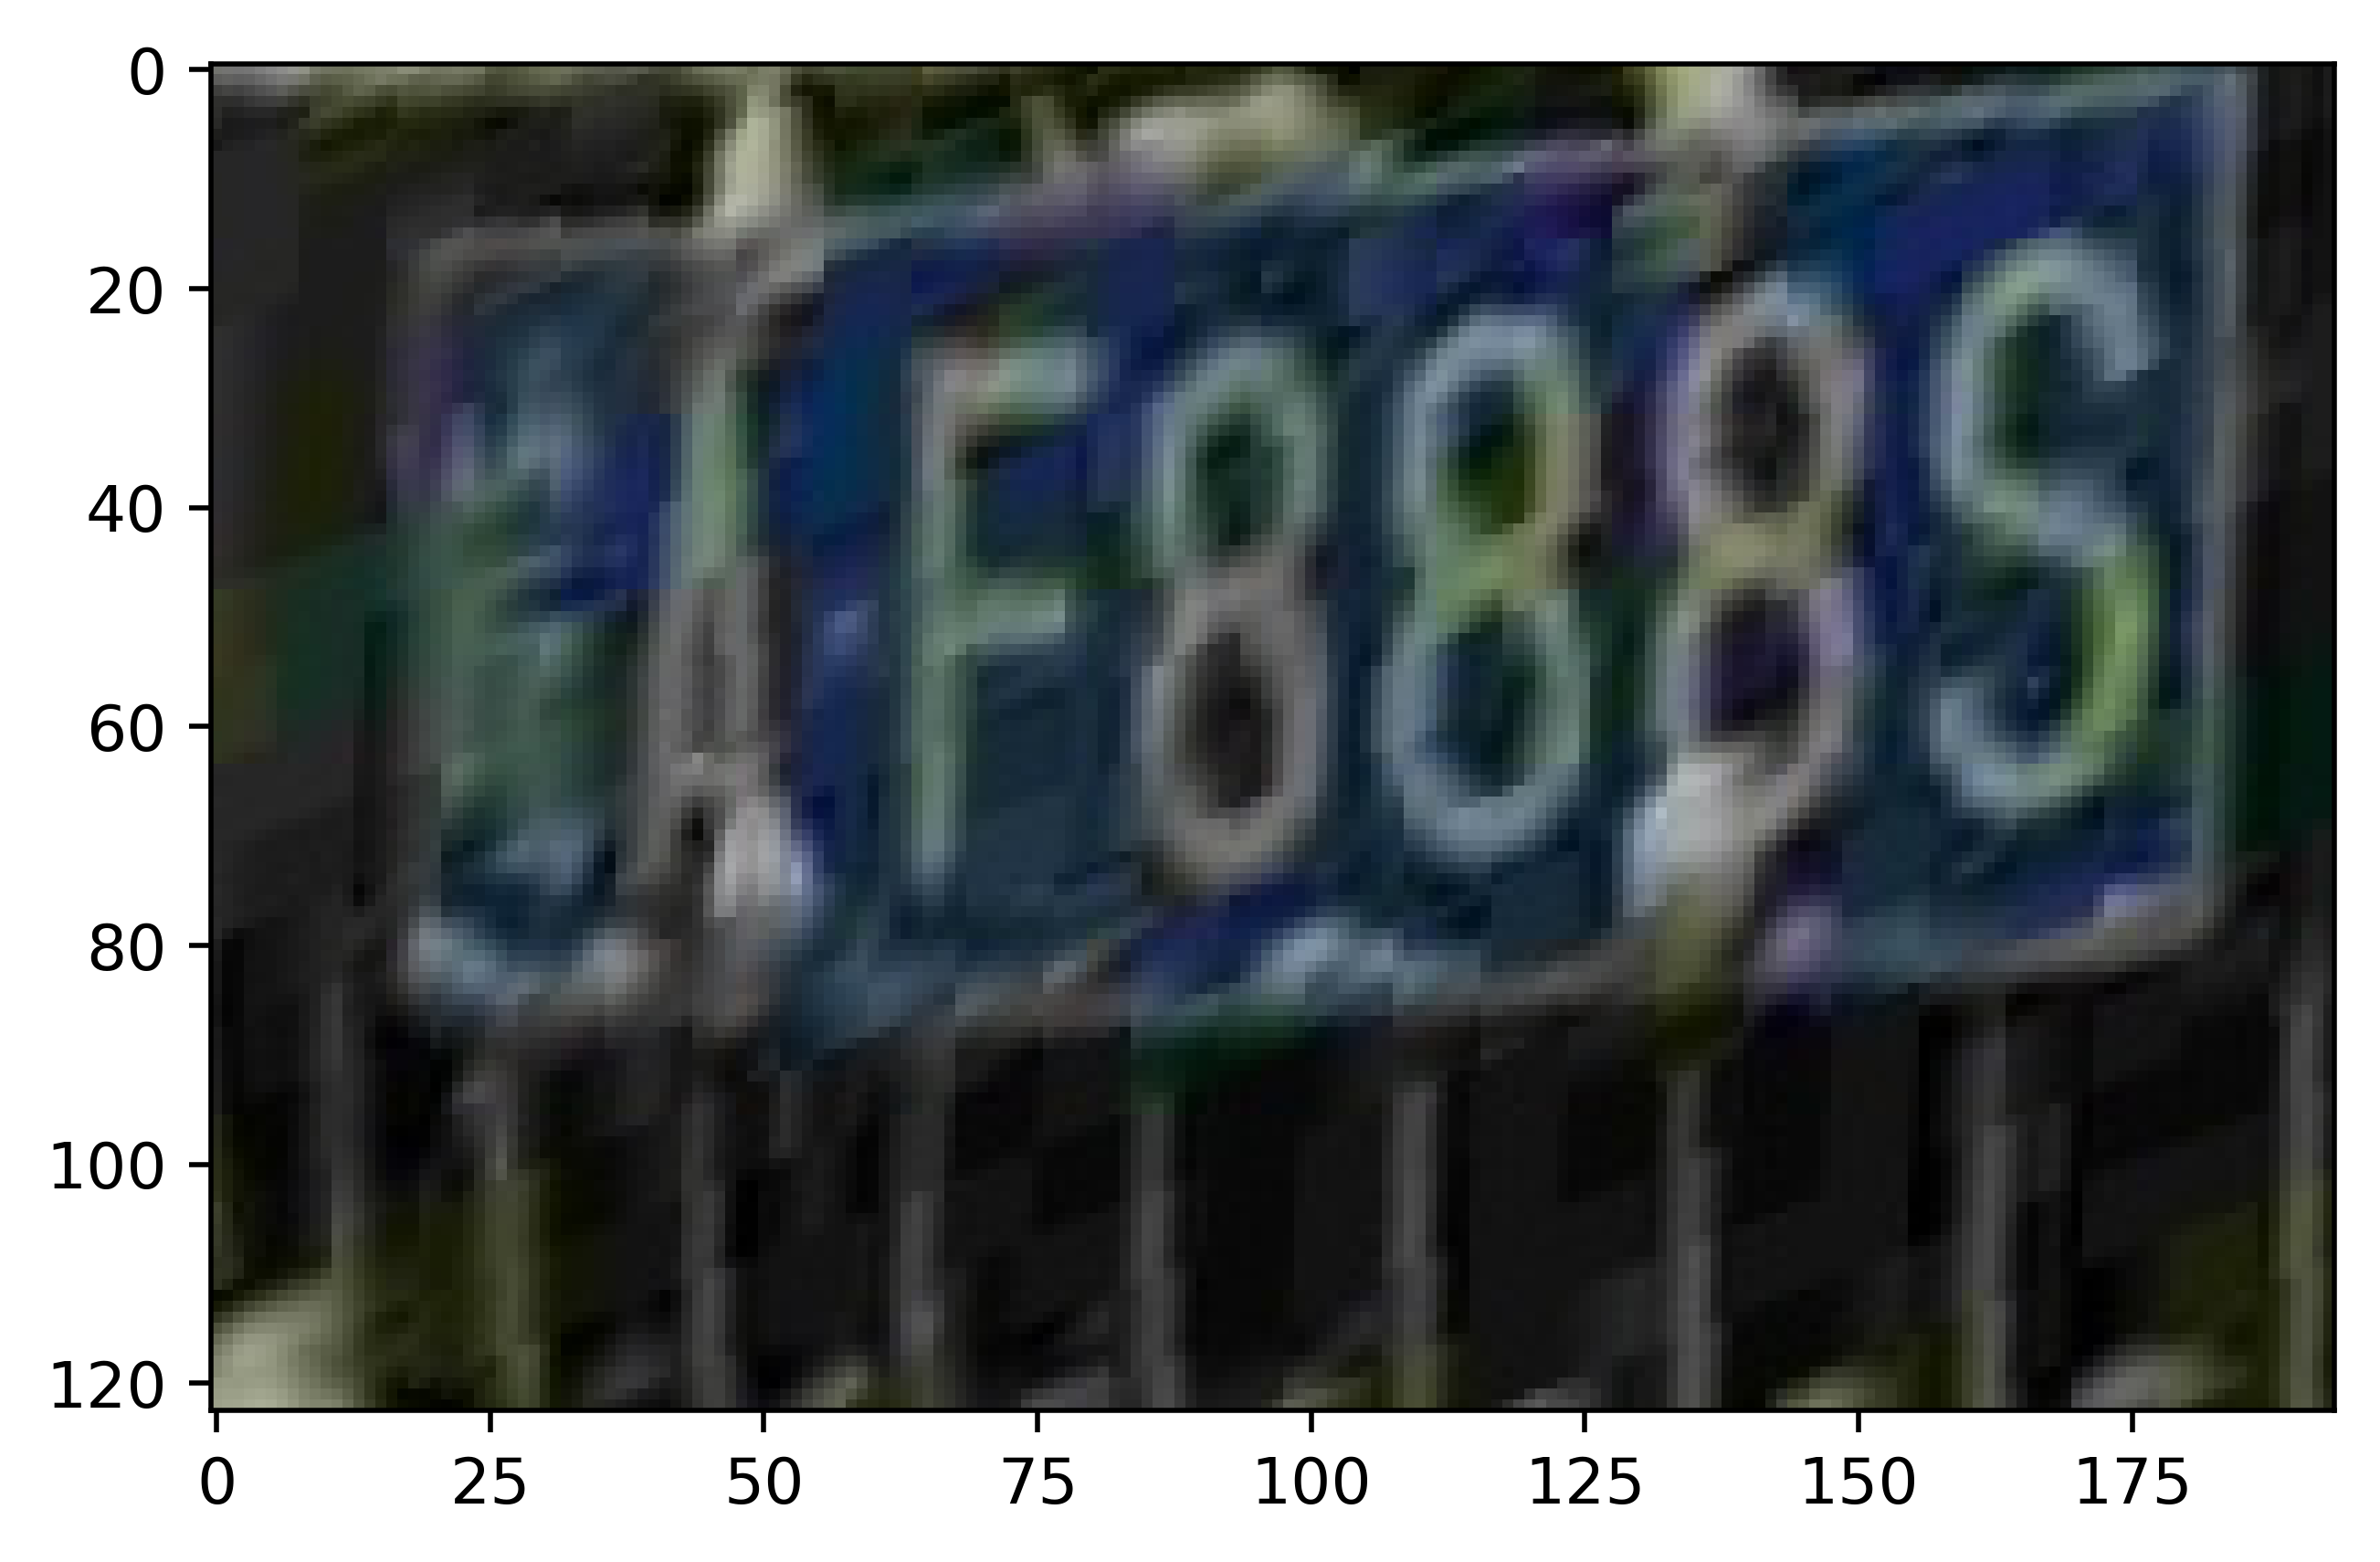

In [ ]:
plt.imshow(Image.open(err_pic[2]))

1) на темные изображения нормалайз действует не в лучшую сторону

2) картинки на самом деле трудные, вторую, например, я не могу прочитать (конечно, не беря в расчет китайский)

3) чтобы улучшить скор модели стоит сделать больше размер батча и увеличить кол-во эпох для обучения, также можно улучшить CNN слой, прогоняя, например, картинки через резнет, чем лучшее у модели представление о картинке более правильно она разпознает что написано

4) можно затемнить картинки и обучить модель на более затемненных изображениях